In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import keras_tuner as kt
import multiprocessing

In [2]:
config = {
    'ROOT_PATH' : 'images',
    'IMG_SIZE' : 200,
    'BATCH_SIZE' : 8
}

In [3]:
data = os.listdir(config['ROOT_PATH'])
len(data)

279

In [4]:
data[:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

In [6]:
patient_10253 = os.listdir(os.path.join(config['ROOT_PATH'], '10253'))

In [7]:
patient_10253_0 = os.listdir(os.path.join(config['ROOT_PATH'], '10253', '0'))
patient_10253_1 = os.listdir(os.path.join(config['ROOT_PATH'], '10253', '1'))

print(patient_10253_0[:5])

print(patient_10253_1[:5])

['10253_idx5_x1001_y1001_class0.png', '10253_idx5_x1001_y1051_class0.png', '10253_idx5_x1001_y1101_class0.png', '10253_idx5_x1001_y1151_class0.png', '10253_idx5_x1001_y1201_class0.png']
['10253_idx5_x501_y351_class1.png', '10253_idx5_x501_y401_class1.png', '10253_idx5_x551_y301_class1.png', '10253_idx5_x551_y351_class1.png', '10253_idx5_x551_y401_class1.png']


In [8]:
df_0 = pd.DataFrame()

for path in patient_10253_0:
    split = path.split('_')
    # Extract elements 2 and 3, substringing the first char
    x_coord = split[2][1:]
    y_coord = split[3][1:]
    idc_class = 0
    
    data = {"path": os.path.join(config['ROOT_PATH'], '10253', '0', path),
            "x_coord": x_coord,
            "y_coord": y_coord,
            "idc_class": idc_class}
    
    df_0 = pd.concat([df_0, pd.DataFrame([data])], ignore_index=True)
    
    
print(df_0)

df_1 = pd.DataFrame()

for path in patient_10253_1:
    split = path.split('_')
    # Extract elements 2 and 3, substringing the first char
    x_coord = split[2][1:]
    y_coord = split[3][1:]
    idc_class = 1
    # Hardcoded path for now, we'll address this later
    data = {"path": os.path.join(config['ROOT_PATH'], '10253', '1', path),
            "x_coord": x_coord,
            "y_coord": y_coord,
            "idc_class": idc_class}
    
    df_1 = pd.concat([df_1, pd.DataFrame([data])], ignore_index=True)
    
    
# Combine dataframes
df = pd.concat([df_0, df_1]).reset_index()
# Convert the coordinates to integers, from objects
df['x_coord'] = df['x_coord'].astype('int')
df['y_coord'] = df['y_coord'].astype('int')

                                                 path x_coord y_coord  \
0    images\10253\0\10253_idx5_x1001_y1001_class0.png    1001    1001   
1    images\10253\0\10253_idx5_x1001_y1051_class0.png    1001    1051   
2    images\10253\0\10253_idx5_x1001_y1101_class0.png    1001    1101   
3    images\10253\0\10253_idx5_x1001_y1151_class0.png    1001    1151   
4    images\10253\0\10253_idx5_x1001_y1201_class0.png    1001    1201   
..                                                ...     ...     ...   
474    images\10253\0\10253_idx5_x951_y651_class0.png     951     651   
475    images\10253\0\10253_idx5_x951_y701_class0.png     951     701   
476    images\10253\0\10253_idx5_x951_y751_class0.png     951     751   
477    images\10253\0\10253_idx5_x951_y801_class0.png     951     801   
478    images\10253\0\10253_idx5_x951_y851_class0.png     951     851   

     idc_class  
0            0  
1            0  
2            0  
3            0  
4            0  
..         ...  
474 

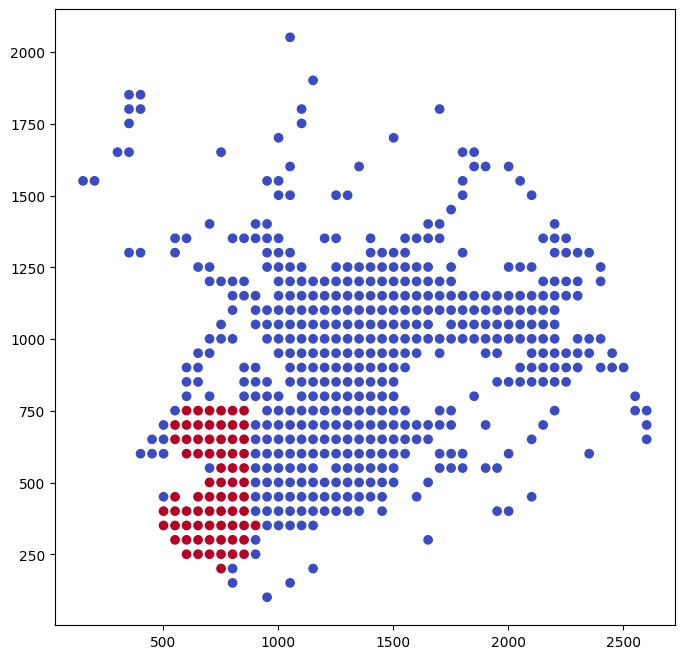

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x = df['x_coord'], y=df['y_coord'], c=df['idc_class'], cmap='coolwarm')
plt.show()

In [10]:
grid = 255*np.ones(shape = (100, 100, 3)).astype(np.uint8)
mask = 255*np.ones(shape = (100, 100, 3)).astype(np.uint8)

In [11]:
print(grid.shape) # (100, 100, 3)

(100, 100, 3)


In [12]:
max_x = df['x_coord'].max()
max_y = df['y_coord'].max()

# Shape of (2101, 2651, 3)
# A placeholder for each pixel, with 3 color options and max values for each channel (RGB)
grid = 255*np.ones(shape = (max_y + 50, max_x + 50, 3)).astype(np.uint8)
mask = 255*np.ones(shape = (max_y + 50, max_x + 50, 3)).astype(np.uint8)

for i in range(len(df)):
        # Get image and label
        image = cv2.imread(df['path'][i])
        idc_class = df['idc_class'][i]
            
        # Extract X and Y coordinates
        x_coord = df['x_coord'][i]
        y_coord = df['y_coord'][i]
        # Add 50 pixels to find ending boundary for each image
        x_end = x_coord + 50
        y_end = y_coord + 50
        
        # Assign image pixel values to placeholder 255 values
        """
        Image is something along the lines of:
        [[[206 164 226]
          [196 154 224]
          [211 175 225]
          ...
          [237 221 240]
          [214 184 232]
          [235 213 243]],
          ...        
        """
        # `grid` will then contain each patch's image values encoded into the grid
        grid[y_coord:y_end, x_coord:x_end] = image
        
        # If `idc_class` is `1`, change the RED channel of the `mask` to 255 (intense red)
        # and other channels to `0` (remove color info, leaving just red)
        if idc_class == 1:
            mask[y_coord:y_end, x_coord:x_end, :1] = 255
            mask[y_coord:y_end, x_coord:x_end, 1:] = 0

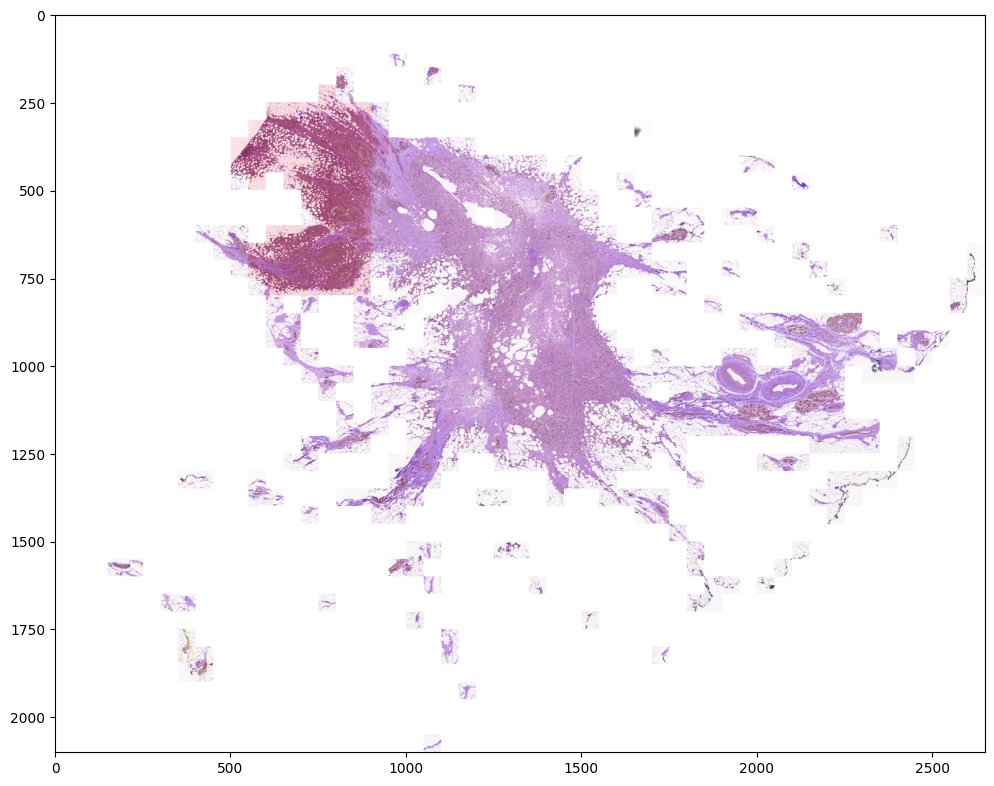

In [13]:
plt.figure(figsize=(12, 12))
plt.imshow(grid)
plt.imshow(mask, alpha=0.1)
plt.show()

In [14]:
data = glob(os.path.join(config['ROOT_PATH'], '*', '*', '*'), recursive=True)
print(len(data))
# 277524

def get_all_dfs():
    dfs = []

    for index, path in enumerate(data):
        split = path.split('_')
        # Extract elements 2 and 3, substringing the first char
        patient_id = split[0].split('\\')[1]
        x_coord = split[2][1:]
        y_coord = split[3][1:]
        idc_class = split[4][-5]
        
        df_data = {"patient_id": patient_id,
                "x_coord": x_coord,
                "y_coord": y_coord,
                "idc_class": idc_class,
                "path": path}
        dfs.append(pd.DataFrame([df_data]))
        print(f'Finished appending {index}/{len(data)}', end='\r')

    df_all = pd.concat(dfs).reset_index(drop=True)
    df_all['x_coord'] = df_all['x_coord'].astype('int')
    df_all['y_coord'] = df_all['y_coord'].astype('int')
    df_all['idc_class'] = df_all['idc_class'].astype('int')
    return df_all
    
df_all = get_all_dfs()

277524


In [15]:
df_all.to_csv('patient_data.csv', index=False)

In [5]:
df_all = pd.read_csv('patient_data.csv')
df_all.head()

patient_id  x_coord  y_coord  idc_class  \
0       10253     1001     1001          0   
1       10253     1001     1051          0   
2       10253     1001     1101          0   
3       10253     1001     1151          0   
4       10253     1001     1201          0   

                                               path  
0  images\10253\0\10253_idx5_x1001_y1001_class0.png  
1  images\10253\0\10253_idx5_x1001_y1051_class0.png  
2  images\10253\0\10253_idx5_x1001_y1101_class0.png  
3  images\10253\0\10253_idx5_x1001_y1151_class0.png  
4  images\10253\0\10253_idx5_x1001_y1201_class0.png

<Axes: xlabel='idc_class', ylabel='count'>

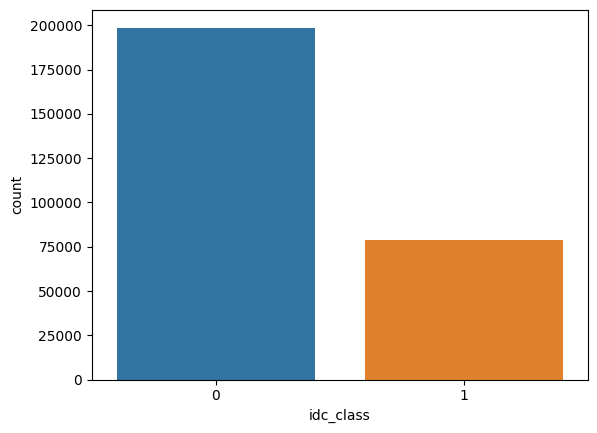

In [17]:
import seaborn as sns
sns.countplot(x='idc_class', data=df_all)

In [18]:
df_all['patient_id'].value_counts()

patient_id
13693    2395
16550    2302
10288    2278
10308    2278
9323     2216
         ... 
16895     151
9175      118
8957      111
9262       94
16534      63
Name: count, Length: 279, dtype: int64

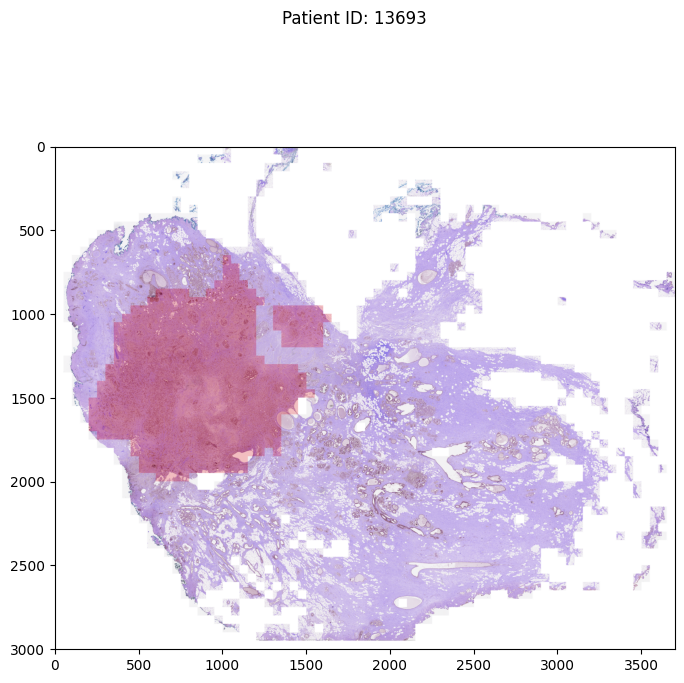

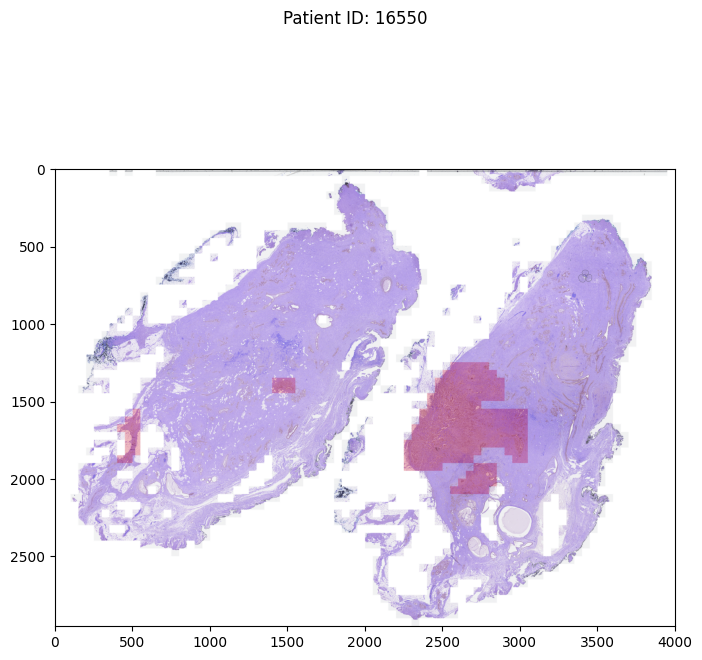

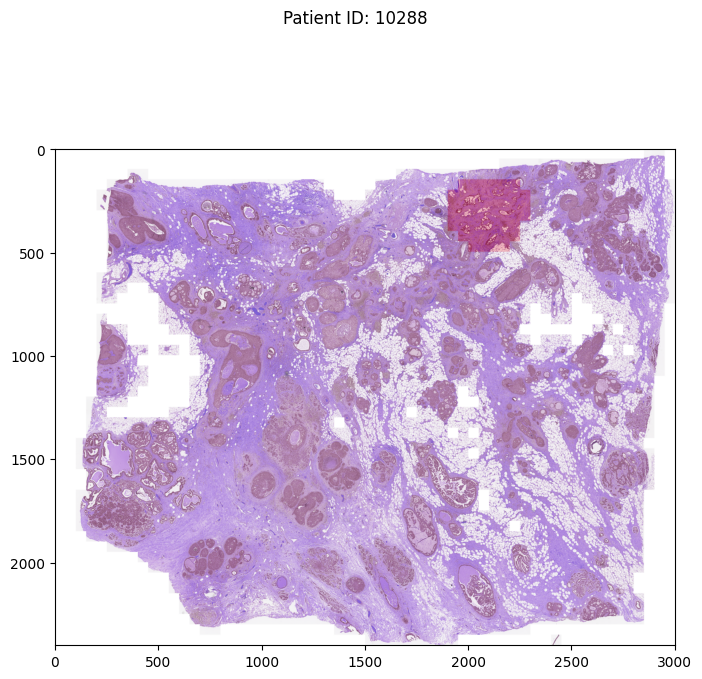

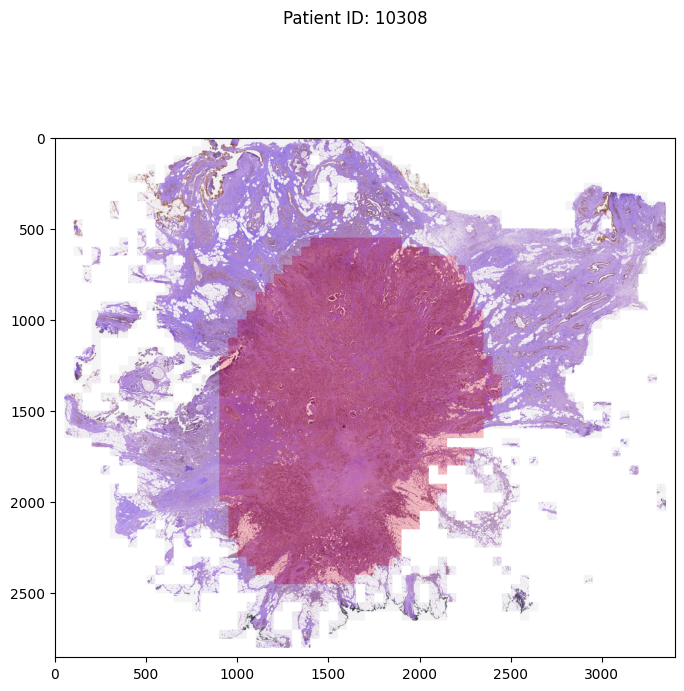

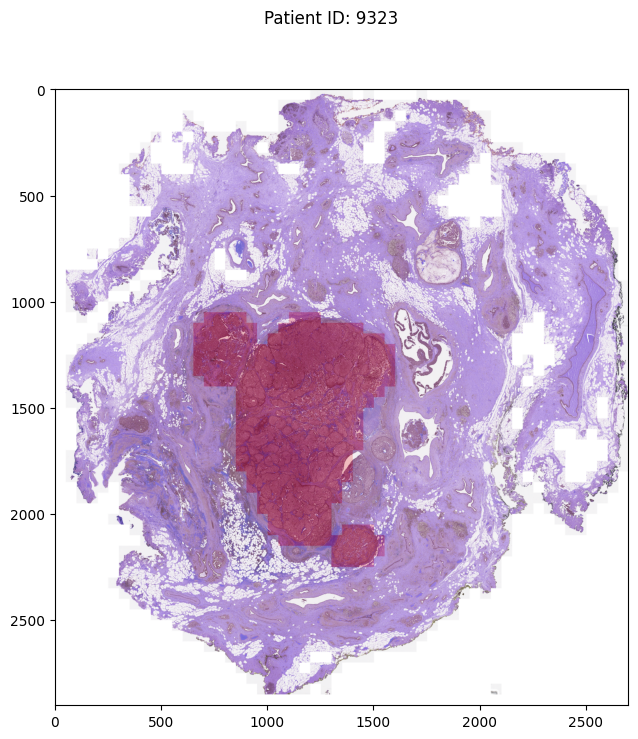

In [19]:
patient_ids = ['13693', '16550', '10288', '10308', '9323']

for patient_id in patient_ids:
    df = df_all.loc[df_all['patient_id'] == patient_id].reset_index(drop=True)
    max_x = df['x_coord'].max()
    max_y = df['y_coord'].max()
    
    grid = 255*np.ones(shape = (max_y + 50, max_x + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_y + 50, max_x + 50, 3)).astype(np.uint8)

    for i in range(len(df)):
        # Get image and label
        image = cv2.imread(df['path'][i])
        # Image shape might not be 50x50, in which case, it's a broken patch
        # and we don't want to load it in
        if(image.shape==(50, 50, 3)):
            idc_class = df['idc_class'][i]
            x_coord = df['x_coord'][i]
            y_coord = df['y_coord'][i]
            x_end = x_coord + 50
            y_end = y_coord + 50
            
            grid[y_coord:y_end, x_coord:x_end] = image

            if idc_class == 1:
                mask[y_coord:y_end, x_coord:x_end, :1] = 255
                mask[y_coord:y_end, x_coord:x_end, 1:] = 0
                
    plt.figure(figsize=(8, 8))
    plt.suptitle(f'Patient ID: {patient_id}')
    plt.imshow(grid)
    plt.imshow(mask, alpha=0.2)
    plt.show()

In [20]:
data = glob(os.path.join(config['ROOT_PATH'], '*', '*', '*'), recursive=True)
x = []
y = []

# Loading in 1000 images
for i in data[7000:8000]:
    if i.endswith('.png'):
        label=i[-5]
        img = cv2.imread(i)
        # Transformation steps, such as resizing
        img = cv2.resize(img,(200,200))
        x.append(img)
        y.append(label)

In [21]:
# Reduce from float32 for memory footprint
x = np.array(x, dtype='float16')
y = np.array(y, dtype='float16')

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y, shuffle=True, test_size=0.3)

import gc
x = None
y = None
gc.collect()

10667

In [22]:
X_train.shape
# (700, 200, 200, 3)

(700, 200, 200, 3)

In [5]:


if not os.path.exists('./hist_images_small/'):
    print('Making folders for hist_images_small')
    os.mkdir('./hist_images_small/')

    os.mkdir('./hist_images_small/train/')
    os.mkdir('./hist_images_small/test/')
    os.mkdir('./hist_images_small/valid/')

    os.mkdir('./hist_images_small/train/0/')
    os.mkdir('./hist_images_small/train/1/')
    os.mkdir('./hist_images_small/test/0/')
    os.mkdir('./hist_images_small/test/1/')
    
    os.mkdir('./hist_images_small/valid/0/')
    os.mkdir('./hist_images_small/valid/1/')

In [6]:
# enumerate() to get `batch_num`, starting at 1
# range() starting at 1000 and incrementing in steps of 1000 towards the fifth of the length of the dataset
# we're loading in only a 10th of the data
data = glob(os.path.join(config['ROOT_PATH'], '*', '*', '*'), recursive=True)
for batch_num, indices in enumerate(range(1000, int(len(data)/10), 1000), 1):
    x = []
    y = []
    
    # Load in `indices-1000` to `indices`
    # 0:1000, 1000:2000, 2000:3000, etc.
    for i in data[indices-500:indices]:
        if i.endswith('.png'):
            label=i[-5]
            img = cv2.imread(i)
            x.append(img)
            y.append(label)
        
    # Create NumPy Arrays from Python lists
    #x = np.array(x, dtype=np.float16)
    #y = np.array(y, dtype=np.float16)
    
    print(f'Processing batch {batch_num}, with images from {indices-1000} to {indices}')
    
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(x,y, shuffle=True, test_size=0.4, stratify=y)
    
    # For each image in `x_train` - save it, including the associated batch_number and sample in the appropriate directory
    for index, img in enumerate(X_train):
        idc_class = y_train[index]
        path = os.path.join('hist_images_small', 'train', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
        cv2.imwrite(path, img.astype('int'))

    for index, img in enumerate(X_test):
        if index%2 == 0:
            idc_class = y_test[index]
            path = os.path.join('hist_images_small', 'test', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
            cv2.imwrite(path, img.astype('int'))
        else:
            idc_class = y_test[index]
            path = os.path.join('hist_images_small', 'valid', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
            cv2.imwrite(path, img.astype('int'))

Processing batch 1, with images from 0 to 1000
Processing batch 2, with images from 1000 to 2000
Processing batch 3, with images from 2000 to 3000
Processing batch 4, with images from 3000 to 4000
Processing batch 5, with images from 4000 to 5000
Processing batch 6, with images from 5000 to 6000
Processing batch 7, with images from 6000 to 7000
Processing batch 8, with images from 7000 to 8000
Processing batch 9, with images from 8000 to 9000
Processing batch 10, with images from 9000 to 10000
Processing batch 11, with images from 10000 to 11000
Processing batch 12, with images from 11000 to 12000
Processing batch 13, with images from 12000 to 13000
Processing batch 14, with images from 13000 to 14000
Processing batch 15, with images from 14000 to 15000
Processing batch 16, with images from 15000 to 16000
Processing batch 17, with images from 16000 to 17000
Processing batch 18, with images from 17000 to 18000
Processing batch 19, with images from 18000 to 19000
Processing batch 20, wit

In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [5]:
train_paths_small = glob(os.path.join('hist_images_small', 'train', '*', '*'), recursive=True)
test_paths_small = glob(os.path.join('hist_images_small', 'test', '*', '*'), recursive=True)
valid_paths_small = glob(os.path.join('hist_images_small', 'valid', '*', '*'), recursive=True)

In [6]:
def get_labels(pathlist):
    labels = []
    for path in pathlist:
        labels.append(int(path.split(os.sep)[2]))
    labels = np.array(labels)
    return labels

In [ ]:

train_labels_small = get_labels(train_paths_small)
test_labels_small = get_labels(test_paths_small)
valid_labels_small = get_labels(valid_paths_small)

In [7]:
print(len(train_paths_small)) # 16085
print(len(test_paths_small))  # 5370
print(len(test_paths_small))  # 5370

12502
4179
4179


In [8]:
train_paths_small[:5]

['hist_images_small\\train\\0\\batch_10_sample_0.png',
 'hist_images_small\\train\\0\\batch_10_sample_1.png',
 'hist_images_small\\train\\0\\batch_10_sample_10.png',
 'hist_images_small\\train\\0\\batch_10_sample_100.png',
 'hist_images_small\\train\\0\\batch_10_sample_101.png']

In [5]:
def preprocess(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size=[config['IMG_SIZE'], config['IMG_SIZE']])
    img = tf.cast(img, tf.float32)
    label = tf.cast(label, tf.float32)

    return img, label
    
def create_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(len(images))
    dataset = dataset.map(preprocess).batch(config['BATCH_SIZE'],
                                            drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
train_set_small = create_dataset(train_paths_small, train_labels_small)
test_set_small = create_dataset(test_paths_small, test_labels_small)
valid_set_small = create_dataset(valid_paths_small, valid_labels_small)

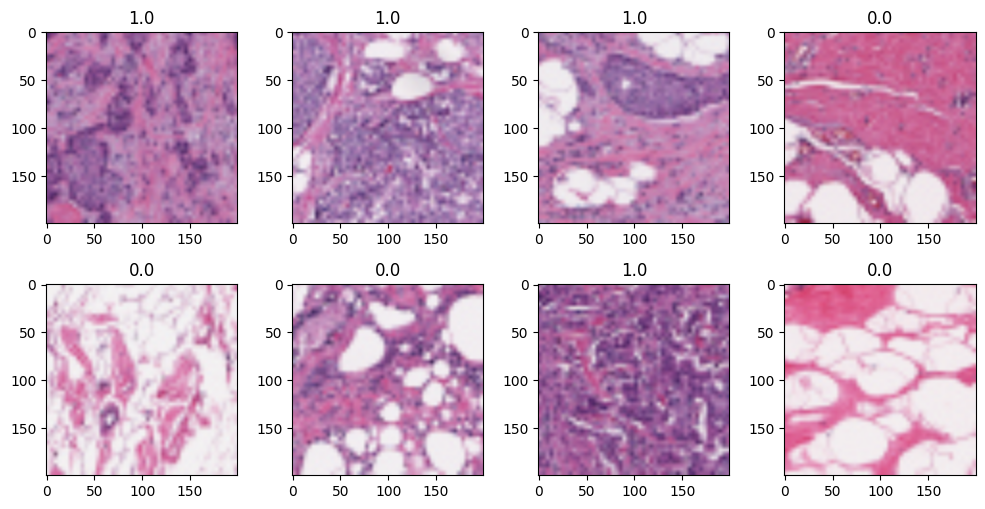

In [32]:
for img_batch, label_batch in valid_set_small.take(1):
    fig = plt.figure(figsize=(10,10))
    for i in range(len(img_batch)):
        ax = fig.add_subplot(4,4,i+1)
        ax.imshow(img_batch[i].numpy().astype('int'))
        ax.set_title(label_batch[i].numpy())
plt.tight_layout()

In [11]:
# Calculate desired shape
X_train_shape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
# Flatten X into a 2D array
X_flattened = X_train.reshape(X_train.shape[0], X_train_shape)

In [12]:
X_train, y_train = SMOTE(random_state=42).fit_resample(X_flattened, y_train)

In [13]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [18]:
class_weights = {0:1, 1:3}

In [20]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomFlip("horizontal"),
        
    keras.layers.Conv2D(32, 3, activation='relu', padding='same',),
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 200, 200, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                  

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_custom.h5', save_best_only=True)
]

history = model.fit(train_set_small,
                     validation_data = valid_set_small,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)

Epoch 1/15
1537/1537 [==============================] - 238s 150ms/step - loss: 0.8990 - binary_accuracy: 0.7202 - precision_1: 0.5999 - recall_1: 0.8622 - auc_1: 0.8170 - val_loss: 1.9362 - val_binary_accuracy: 0.6083 - val_precision_1: 0.2000 - val_recall_1: 6.2696e-04 - val_auc_1: 0.7784
Epoch 2/15
1537/1537 [==============================] - 226s 147ms/step - loss: 0.7753 - binary_accuracy: 0.7464 - precision_1: 0.6205 - recall_1: 0.9104 - auc_1: 0.8525 - val_loss: 0.6445 - val_binary_accuracy: 0.7652 - val_precision_1: 0.7934 - val_recall_1: 0.5395 - val_auc_1: 0.8735
Epoch 3/15
1537/1537 [==============================] - 231s 150ms/step - loss: 0.7626 - binary_accuracy: 0.7485 - precision_1: 0.6235 - recall_1: 0.9061 - auc_1: 0.8594 - val_loss: 0.4268 - val_binary_accuracy: 0.8020 - val_precision_1: 0.7627 - val_recall_1: 0.7148 - val_auc_1: 0.8822
Epoch 4/15
1537/1537 [==============================] - 230s 149ms/step - loss: 0.7525 - binary_accuracy: 0.7571 - precision_1: 0.63

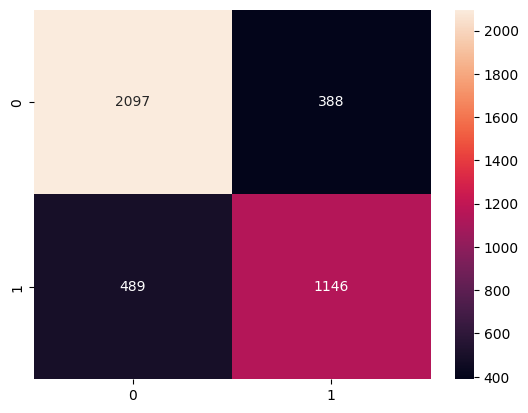

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      2485
         1.0       0.75      0.70      0.72      1635

    accuracy                           0.79      4120
   macro avg       0.78      0.77      0.78      4120
weighted avg       0.79      0.79      0.79      4120



In [23]:
# Load the best saved model, not necesarily the last
model = keras.models.load_model('breast_cancer_custom.h5')

# To hold true and predicted labels
y_pred = np.array([])
y_true_small = np.array([])
count = 0

# Shuffling a set means shuffling it during inference too.
# We can't just stack and re-use the `y_true_small` array unfortunately.
# We'll have to iterate, predict and store ground truth every time.
for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()
# Print classification report
print(classification_report(y_true_small, np.round(y_pred)))

In [18]:
model2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomFlip("horizontal"),
    keras.applications.EfficientNetV2S(weights='imagenet',include_top=False), 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 200, 200, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                        

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnetv2s.h5', save_best_only=True),
]

model2.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history2 = model2.fit(train_set_small,
                     validation_data = valid_set_small,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)

Epoch 1/15
1550/1550 [==============================] - 718s 445ms/step - loss: 0.7266 - binary_accuracy: 0.7744 - precision: 0.6560 - recall: 0.9054 - auc: 0.8761 - val_loss: 0.3860 - val_binary_accuracy: 0.8486 - val_precision: 0.7395 - val_recall: 0.9542 - val_auc: 0.9397
Epoch 2/15
1550/1550 [==============================] - 664s 429ms/step - loss: 0.6318 - binary_accuracy: 0.8123 - precision: 0.6968 - recall: 0.9316 - auc: 0.9036 - val_loss: 0.3946 - val_binary_accuracy: 0.8251 - val_precision: 0.6981 - val_recall: 0.9847 - val_auc: 0.9423
Epoch 3/15
1550/1550 [==============================] - 683s 441ms/step - loss: 0.5872 - binary_accuracy: 0.8291 - precision: 0.7192 - recall: 0.9328 - auc: 0.9158 - val_loss: 0.3430 - val_binary_accuracy: 0.8672 - val_precision: 0.7641 - val_recall: 0.9628 - val_auc: 0.9498
Epoch 4/15
1550/1550 [==============================] - 660s 426ms/step - loss: 0.5711 - binary_accuracy: 0.8349 - precision: 0.7274 - recall: 0.9333 - auc: 0.9205 - val_lo

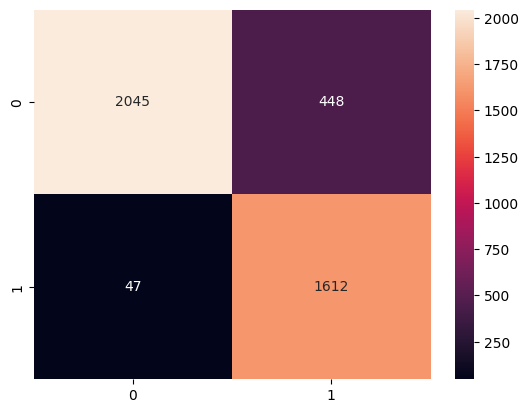

              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89      2493
         1.0       0.78      0.97      0.87      1659

    accuracy                           0.88      4152
   macro avg       0.88      0.90      0.88      4152
weighted avg       0.90      0.88      0.88      4152



In [20]:
model2 = keras.models.load_model('breast_cancer_effnetv2s.h5')

y_pred = np.array([])
y_true_small = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model2(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(classification_report(y_true_small, np.round(y_pred)))

519/519 [==============================] - 51s 92ms/step - loss: 0.2805 - binary_accuracy: 0.8808 - precision: 0.7826 - recall: 0.9717 - auc: 0.9605
              Recall  Precision       AUC
Custom CNN  0.696203   0.756385  0.877688
EffNetV2S   0.971687   0.782630  0.960454


<Axes: xlabel='variable', ylabel='value'>

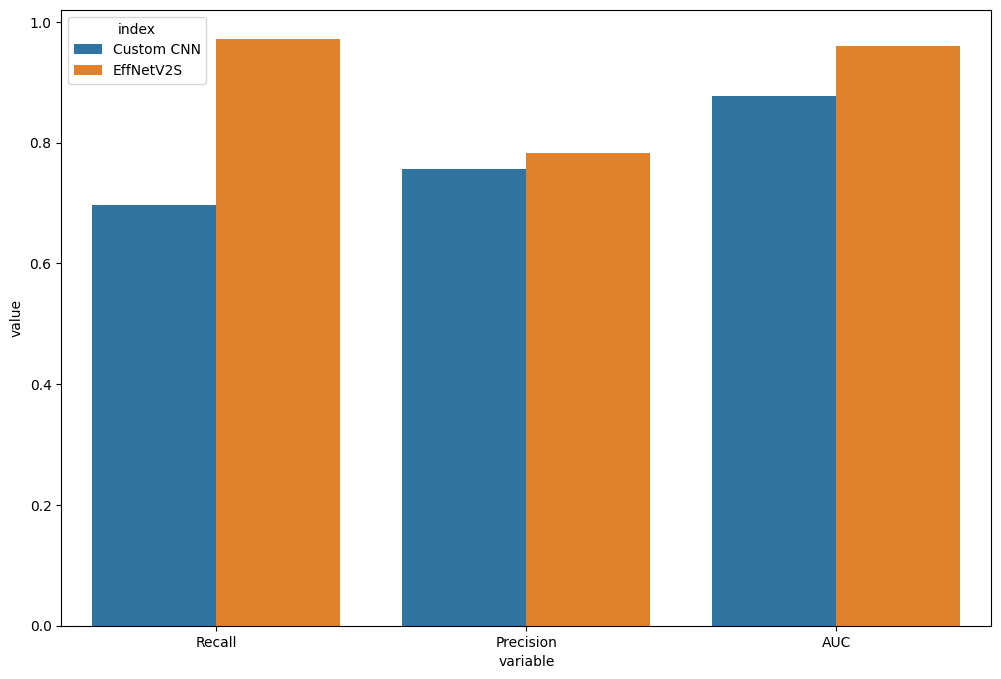

In [22]:
# Evaluate the models to get performance stats
preds_custom = model.evaluate(test_set_small)
preds_effnet = model2.evaluate(test_set_small)

# Extract into relevant model-related stats
cnn_recall, cnn_precision, cnn_auc, cnn_params = preds_custom[3], preds_custom[2], preds_custom[4], model.count_params()
effnet_recall, effnet_precision, effnet_auc, effnet_params = preds_effnet[3], preds_effnet[2], preds_effnet[4], model2.count_params()

# Create dict to hold values
data = {
    'Custom CNN' : [cnn_recall, cnn_precision, cnn_auc],
    'EffNetV2S' : [effnet_recall, effnet_precision, effnet_auc]
}

# Dict to DF
df = pd.DataFrame(data, index = ["Recall", "Precision", "AUC"]).T

print(df)

fig, ax = plt.subplots(figsize=(12, 8))

df_bar = df.reset_index().melt(id_vars=["index"])
sns.barplot(x="variable", y="value", hue="index", data=df_bar, ax=ax)

In [15]:
def build_effnet(hp):
    model = keras.Sequential()
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(hp.Choice('random_rot', [0.10, 0.15, 0.20, 0.3])),
    keras.layers.RandomZoom(hp.Choice('random_zoom', [0.10, 0.15, 0.20, 0.3])),
    keras.layers.RandomFlip(hp.Choice('flip', ['horizontal', 'vertical', 'horizontal_and_vertical'])),
    model.add(keras.applications.EfficientNetV2S(weights='imagenet', include_top=False))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                 optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'nadam']),
                 metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

    return model

In [16]:
tuner = kt.Hyperband(
    build_effnet,
    objective='val_loss',
    max_epochs=5)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [17]:
tuner.search(train_set_small, epochs=5, validation_data=valid_set_small)

Trial 10 Complete [00h 48m 52s]
val_loss: 0.1636861264705658

Best val_loss So Far: 0.1636861264705658
Total elapsed time: 01h 41m 16s
INFO:tensorflow:Oracle triggered exit


In [18]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0009 summary
Hyperparameters:
random_rot: 0.3
random_zoom: 0.2
flip: vertical
dropout: 0.2
optimizer: sgd
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.1636861264705658

Trial 0005 summary
Hyperparameters:
random_rot: 0.3
random_zoom: 0.3
flip: horizontal_and_vertical
dropout: 0.4
optimizer: sgd
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0003
Score: 0.20299044251441956

Trial 0006 summary
Hyperparameters:
random_rot: 0.15
random_zoom: 0.15
flip: horizontal
dropout: 0.2
optimizer: sgd
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0000
Score: 0.20635110139846802

Trial 0003 summary
Hyperparameters:
random_rot: 0.3
random_zoom: 0.3
flip: horizontal_and_vertical
dropout: 0.4
optimizer: sgd
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/roun

In [19]:
tuned_model = tuner.get_best_models()[0]

In [20]:
tuned_model.save('breast_cancer_tuned_baseline.h5')

In [12]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    # Calculate true positives, true negatives, false positives and false negatives
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Calculate precision and recall
    # Adding epsilon (small value) to combat potential division by 0
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    # Calculate F1
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
  
def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    # Minimizing 1-F1 is equal to maximizing F1
    return 1 - K.mean(f1)

In [23]:
# Load model
model_f1_loss = keras.models.load_model('breast_cancer_tuned_baseline.h5', custom_objects={'f1':f1})

# Save under another name to not overwrite baseline
callbacks = [
    keras.callbacks.EarlyStopping(patience=6),
    keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnet_f1_loss.h5',  save_best_only=True, monitor="val_f1"),
    keras.callbacks.ReduceLROnPlateau(patience=5)
]

model_f1_loss.compile(loss=f1_loss,
              optimizer='sgd',
              metrics=[
                  f1,
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

model_f1_loss_history = model_f1_loss.fit(train_set_small,
                     validation_data=valid_set_small,
                     callbacks=callbacks,
                     epochs=15,
                    class_weight=class_weights)

Epoch 1/15
1562/1562 [==============================] - 573s 357ms/step - loss: 0.1752 - f1: 0.9082 - binary_accuracy: 0.9417 - precision_1: 0.9113 - recall_1: 0.9464 - auc_1: 0.9811 - val_loss: 0.1128 - val_f1: 0.8971 - val_binary_accuracy: 0.9296 - val_precision_1: 0.8848 - val_recall_1: 0.9479 - val_auc_1: 0.9723 - lr: 0.0100
Epoch 2/15
1562/1562 [==============================] - 555s 355ms/step - loss: 0.1412 - f1: 0.9186 - binary_accuracy: 0.9502 - precision_1: 0.9241 - recall_1: 0.9541 - auc_1: 0.9814 - val_loss: 0.1074 - val_f1: 0.9023 - val_binary_accuracy: 0.9363 - val_precision_1: 0.9119 - val_recall_1: 0.9310 - val_auc_1: 0.9720 - lr: 0.0100
Epoch 3/15
1562/1562 [==============================] - 553s 354ms/step - loss: 0.1274 - f1: 0.9252 - binary_accuracy: 0.9561 - precision_1: 0.9336 - recall_1: 0.9584 - auc_1: 0.9839 - val_loss: 0.1041 - val_f1: 0.8989 - val_binary_accuracy: 0.9409 - val_precision_1: 0.9053 - val_recall_1: 0.9520 - val_auc_1: 0.9751 - lr: 0.0100
Epoch 4

In [ ]:
model_f1_loss = keras.models.load_model('breast_cancer_effnet_f1_loss.h5')

y_pred = np.array([])
y_true_small = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model_f1_loss(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(classification_report(y_true_small, np.round(y_pred)))

In [8]:
if not os.path.exists('./hist_images/'):
    print('Making folders for hist_images')
    os.mkdir('./hist_images/')

    os.mkdir('./hist_images/train/')
    os.mkdir('./hist_images/test/')
    os.mkdir('./hist_images/valid/')

    os.mkdir('./hist_images/train/0/')
    os.mkdir('./hist_images/train/1/')
    os.mkdir('./hist_images/test/0/')
    os.mkdir('./hist_images/test/1/')
    
    os.mkdir('./hist_images/valid/0/')
    os.mkdir('./hist_images/valid/1/')
    
    print('hist_images not processed, processing now')
    for batch_num, indices in enumerate(range(1000, len(data), 1000), 1):
        X = []
        y = []

        for i in data[indices-1000:indices]:
            if i.endswith('.png'):
                label=i[-5]
                img = cv2.imread(i)
                if img.shape == (50, 50, 3):
                    X.append(img)
                    y.append(label)

        #X = np.array(X)
        #y = np.array(y)

        print(f'Processing batch {batch_num}, with images from {indices-1000} to {indices}', end='\r')

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, stratify=y)

        for index, img in enumerate(X_train):
            idc_class = y_train[index]
            path = os.path.join('hist_images', 'train', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
            cv2.imwrite(path, img.astype('int'))

        for index, img in enumerate(X_test):
            if index%2 == 0:
                idc_class = y_test[index]
                path = os.path.join('hist_images', 'test', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
                cv2.imwrite(path, img.astype('int'))
            else:
                idc_class = y_test[index]
                path = os.path.join('hist_images', 'valid', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
                cv2.imwrite(path, img.astype('int'))

Making folders for hist_images
hist_images not processed, processing now


In [7]:
train_paths = glob(os.path.join('hist_images', 'train', '*', '*'), recursive=True)
test_paths = glob(os.path.join('hist_images', 'test', '*', '*'), recursive=True)
valid_paths = glob(os.path.join('hist_images', 'valid', '*', '*'), recursive=True)

In [8]:
print(len(train_paths)) # 164759
print(len(test_paths))  # 54996
print(len(test_paths))  # 54996

164759
54996
54996


In [9]:
train_labels = get_labels(train_paths)
test_labels = get_labels(test_paths)
valid_labels = get_labels(valid_paths)

In [10]:
train_set = create_dataset(train_paths, train_labels)
test_set = create_dataset(test_paths, test_labels)
valid_set = create_dataset(valid_paths, valid_labels)

In [ ]:
model_tuned = keras.models.load_model('breast_cancer_tuned_baseline.h5', custom_objects={'f1':f1})

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnet_tuned.h5',  save_best_only=True, monitor="val_f1"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5)
]

model_tuned.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[
                  f1,
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

model_tuned_history = model_tuned.fit(train_set,
                     validation_data=valid_set,
                     callbacks=callbacks,
                     epochs=15,
                    class_weight=class_weights)

Epoch 1/15
20594/20594 [==============================] - 7485s 362ms/step - loss: 0.5131 - f1: 0.7276 - binary_accuracy: 0.8535 - precision: 0.6886 - recall: 0.8919 - auc: 0.9357 - val_loss: 0.3171 - val_f1: 0.7470 - val_binary_accuracy: 0.8708 - val_precision: 0.7058 - val_recall: 0.9394 - val_auc: 0.9592 - lr: 0.0100
Epoch 2/15
20594/20594 [==============================] - 7292s 354ms/step - loss: 0.4302 - f1: 0.7567 - binary_accuracy: 0.8787 - precision: 0.7318 - recall: 0.9101 - auc: 0.9540 - val_loss: 0.2987 - val_f1: 0.7575 - val_binary_accuracy: 0.8785 - val_precision: 0.7186 - val_recall: 0.9447 - val_auc: 0.9642 - lr: 0.0100
Epoch 3/15
20594/20594 [==============================] - 7292s 354ms/step - loss: 0.3903 - f1: 0.7717 - binary_accuracy: 0.8905 - precision: 0.7523 - recall: 0.9209 - auc: 0.9619 - val_loss: 0.2912 - val_f1: 0.7581 - val_binary_accuracy: 0.8824 - val_precision: 0.7296 - val_recall: 0.9347 - val_auc: 0.9634 - lr: 0.0100
Epoch 4/15
 2833/20594 [===>......

In [13]:
model_tuned = keras.models.load_model('breast_cancer_effnet_tuned.h5', custom_objects={'f1':f1})

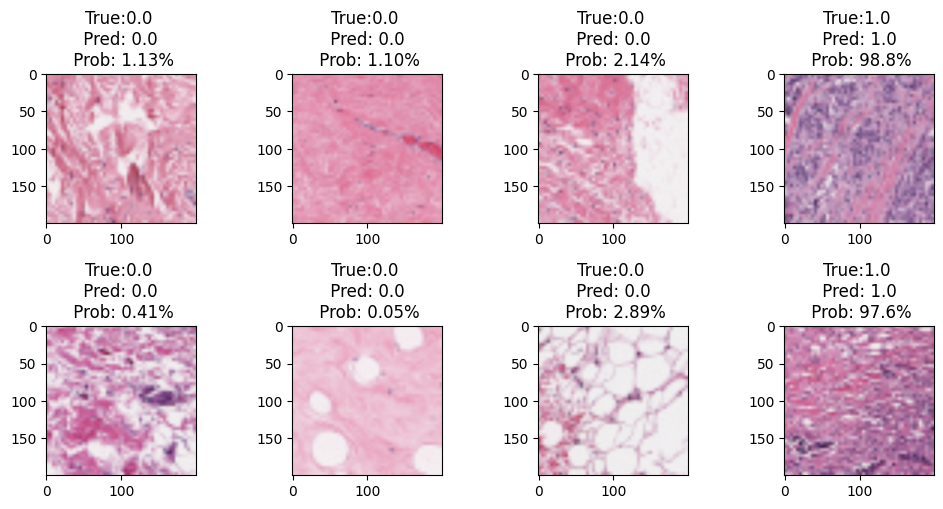

In [14]:
for img_batch, label_batch in test_set.take(1):
    fig = plt.figure(figsize=(10,10))
    for i in range(len(img_batch)):
        ax = fig.add_subplot(4,4,i+1)
        ax.imshow(img_batch[i].numpy().astype('int'))
    
        
        image = np.expand_dims(img_batch[i], 0)
        pred = model_tuned(image)
        pred = np.squeeze(pred)
        
        ax.set_title(f'True:{label_batch.numpy()[i]} \n Pred: {np.round(pred)} \n Prob: {str(pred*100)[:4]}%')
plt.tight_layout()

In [16]:
y_pred = np.array([])
y_true = np.array([])
count = 0

for x, y in test_set:
    print(f'Evaluating batch {count}/{len(test_set)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model_tuned(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(classification_report(y_true, np.round(y_pred)))

ValueError: Found input variables with inconsistent numbers of samples: [0, 54992]